We want to give a KAN and a MLP a shot at predicting the values of a non-linear equation. We want to compare the results between the architectures and we want to see how various depths and widths of KAN perform.

The equation in question is $y = \text{min}(0, y_0 - \alpha (x - x_0)² ); x = w / h$ with $w$ being the weight and $h$ being the height.

In [1]:
from kan import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_tweedie_deviance
from sklearn.preprocessing import MinMaxScaler

torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Generate the synthetic data

In [2]:
h = 1.85 + 0.1 * np.random.randn(10_000)
w = 13.4 * (h ** 3) * (0.5 + 0.5 / 0.89 * skewnorm.rvs(5, size=10_000))
x = w / h

# Some constants with the assumption that there is a max jump height y0 to be reached by a person of 1.85 m and 85 kg. Which is stupid, I know, but this is a toy example.
y0 = 0.8
x0 = 85 / 1.85
alpha = 0.8

y = np.clip(y0 - alpha * ((x - x0) / x0)**2, 0.0, 1_000)

In [3]:
# For the training data, we want to normalise our data. Wild, right?
height_scaler = MinMaxScaler().fit(h.reshape((-1, 1)))
weight_scaler = MinMaxScaler().fit(w.reshape((-1, 1)))

hn = height_scaler.transform(h.reshape((-1, 1))).squeeze()
wn = weight_scaler.transform(w.reshape((-1, 1))).squeeze()

In [4]:
train_test_split = 0.8
N_train = int(len(h) * train_test_split)
N_test = len(h) - N_train

train_input = torch.zeros(N_train, 2)
test_input = torch.zeros(N_test, 2)

train_input[:, 0] = torch.from_numpy(hn[:N_train])
train_input[:, 1] = torch.from_numpy(wn[:N_train])

train_label = torch.from_numpy(y[:N_train])

test_input[:, 0] = torch.from_numpy(hn[N_train:])
test_input[:, 1] = torch.from_numpy(wn[N_train:])

test_label = torch.from_numpy(y[N_train:])

dataset = {
    'train_input': train_input.to(device),
    'test_input': test_input.to(device),
    'train_label': train_label.unsqueeze(dim=1).to(device),
    'test_label': test_label.unsqueeze(dim=1).to(device),
}

# Let's have separate sets for the MLP:
X_train = np.zeros((N_train, 2))
X_train[:, 0] = hn[:N_train]
X_train[:, 1] = wn[:N_train]
y_train = y[:N_train]

X_test = np.zeros((N_test, 2))
X_test[:, 0] = hn[N_train:]
X_test[:, 1] = wn[N_train:]
y_test = y[N_train:]

# Train the KAN

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.80e-02 | test_loss: 2.86e-02 | reg: 3.01e+00 | : 100%|█| 50/50 [01:07<00:00,  1.36s/


saving model version 0.1


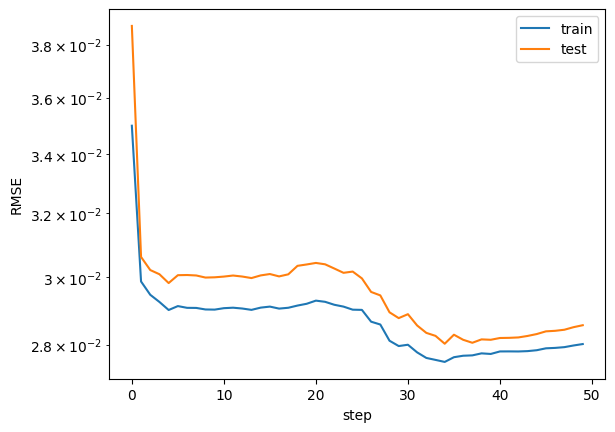

In [5]:
# Train a KAN, starting from: with two features, 1D output and two layers, initially, starting with cubic splines and five grid intervals, which will be subsequently increased.
# However, since the example is easy and analytical, and we had a few runs before, we know that a small structure is good enough and more does not help.
grids = [5]#, 10, 20]

train_losses = []
test_losses = []

for i, grid_size in enumerate(grids):
    if i == 0:
        kan_mdl = KAN(width=[2, 4, 1], grid=grid_size, k=3, seed=230948, device=device)
    else:
        kan_mdl = kan_mdl.refine(grid_size)
    res = kan_mdl.fit(dataset, opt="LBFGS", steps=50, lamb=0.001);
    train_losses += res['train_loss']
    test_losses += res['test_loss']

plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

We found that there is no marked gain from a higher grid resolution and actually things got worse. Probably because the task was so easy and monotonic in its behaviour. After all, it was basically a quadratic function with some offset.

So we turned off the grid size expansion and called it a day.

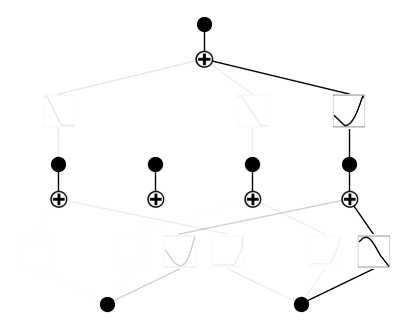

In [6]:
# Plot the trained model:
kan_mdl.plot()

Text(0, 0.5, 'inferred label')

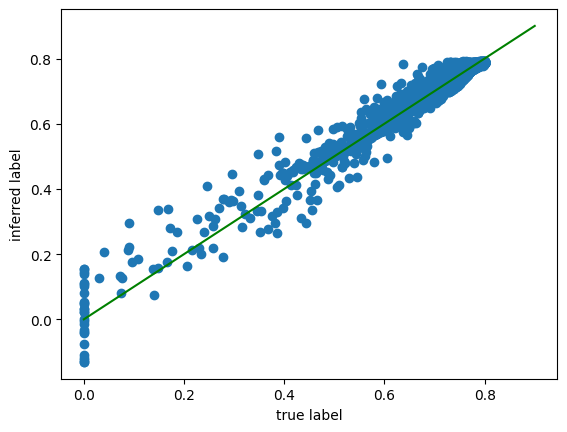

In [7]:
plt.scatter(dataset['test_label'].detach().numpy(), kan_mdl.forward(dataset['test_input']).detach().numpy())
plt.plot([0, 0.9], [0, 0.9], 'g')
plt.xlabel('true label')
plt.ylabel('inferred label')

**Note**: We are **not** pruning the model here, as that shifts all predictions down by 0.2. Bad pruning.

# Train a MLP for comparison

In [8]:
mdl_mlp = MLPRegressor(hidden_layer_sizes=(10, 10))
mdl_mlp.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(10, 10))

# Model comparison

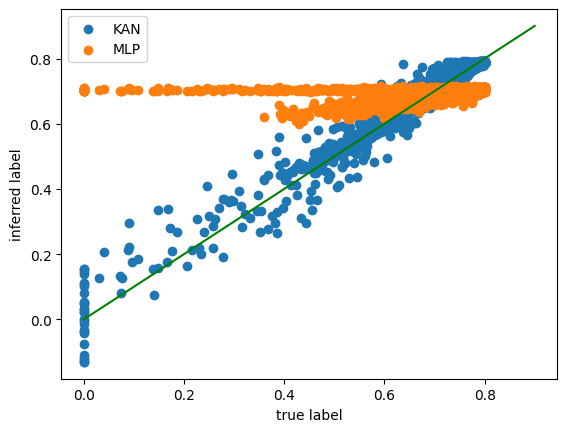

In [9]:
plt.scatter(dataset['test_label'].detach().numpy(), kan_mdl.forward(dataset['test_input']).detach().numpy())
plt.scatter(y_test, mdl_mlp.predict(X_test))
plt.plot([0, 0.9], [0, 0.9], 'g')
plt.xlabel('true label')
plt.ylabel('inferred label')
plt.legend(['KAN', 'MLP'])

In [10]:
y_kan = kan_mdl.forward(dataset['test_input']).detach().numpy()
y_mlp = mdl_mlp.predict(X_test)

In [11]:
# Calculate the quadratic error, Poisson deviance and Gamma deviance by calculating the Tweedie deviance with the respective powers.
# For more information, see https://scikit-learn.org/dev/modules/model_evaluation.html.
metrics = pd.DataFrame({
    'k': [0, 1, 2],
    'kan': [
        mean_tweedie_deviance(
            np.clip(y_test, a_min=1e-3, a_max=max(y_test)), 
            np.clip(y_kan, a_min=(1 - (k > 0)) * (-1000) + 1e-3, a_max=1000), 
            power=k
        ) 
        for k in range(3)
    ],
    'mlp': [
        mean_tweedie_deviance(
            np.clip(y_test, a_min=1e-3, a_max=max(y_test)), 
            np.clip(y_mlp, a_min=(1 - (k > 0)) * (-1000) + 1e-3, a_max=1000), 
            power=k
        ) 
        for k in range(3)
    ],
})
metrics.assign(
    winner = ['kan' if metrics.loc[k, 'kan'] <= metrics.loc[k, 'mlp'] else 'mlp' for k in metrics.k],
    kan_rel = metrics.kan / metrics.mlp,
)

,k,kan,mlp,winner,kan_rel
0,0,0.000815,0.019637,kan,0.041512
1,1,0.002925,0.041691,kan,0.070160
2,2,0.055398,0.196188,kan,0.282371


In all three metrics, the KAN wins out over the MLP, having less than half the error the MLP has. Both errors are already decent, though, and there does not seem to be a huge difference between both approaches. Still interesting to see how well the KAN wins out.

One thing to note is, however, that the MLP-results are very inconsistent and there are training runs where the MLP wins out.